<a href="https://colab.research.google.com/github/hrithikwel8/Rossmann_Sales_Prediction/blob/main/Hrithik_Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import random

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path = '/content/drive/MyDrive/Rossmann Sales Prediction/'
store_data_df = pd.read_csv(path + 'Rossmann Stores Data.csv')
store_df = pd.read_csv(path + 'store.csv')

#Model Building

Split the data by date to test the model predictions.
We will use the last 6 weeks' data as the test case for our model.
So, we will train our model on the remaining data.

In [ ]:
# split the dataset in 2 by dates, for test on last 6 weeks
# first sort the model data 
sorted_sales_df = sales_df.sort_values(by=['Year','Month','Day'],ascending=False)
sorted_sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,public_holiday,easter_holiday,christmas,Year,Month,Day,Sales_log_t,Customers_log_t,CompetitionDistance,Store_Type,Assortment_Level,Promo_cont,CompetitionTime
0,1,5,5263,555,1,1,1,0,0,0,2015,7,31,8.568646,6.320768,1270.0,3,1,0,2524
942,2,5,6064,625,1,1,1,0,0,0,2015,7,31,8.710290,6.439350,570.0,1,1,1,2829
1884,3,5,8314,821,1,1,1,0,0,0,2015,7,31,9.025816,6.711740,14130.0,1,1,1,3164
2826,4,5,13995,1498,1,1,1,0,0,0,2015,7,31,9.546527,7.312553,620.0,3,3,0,2159
3768,5,5,4822,559,1,1,1,0,0,0,2015,7,31,8.481151,6.327937,29910.0,1,1,0,121


In [ ]:
# get split date
last_date = date(int(sorted_sales_df.iloc[0]['Year']),int(sorted_sales_df.iloc[0]['Month']),int(sorted_sales_df.iloc[0]['Day'])) 
last_loc = len(sorted_sales_df) - 1
first_date = date(int(sorted_sales_df.iloc[last_loc]['Year']),int(sorted_sales_df.iloc[last_loc]['Month']),int(sorted_sales_df.iloc[last_loc]['Day']))
split_date = last_date - timedelta(6*7) # remove 6 weeks from last date of data
split_date 

datetime.date(2015, 6, 19)

In [ ]:
# find index of split date
index = 0
for i in range(len(sorted_sales_df)):
  year = int(sorted_sales_df.iloc[i]['Year'])
  month = int(sorted_sales_df.iloc[i]['Month'])
  day = int(sorted_sales_df.iloc[i]['Day'])
  if ((year == split_date.year) and (month == split_date.month) and (day == split_date.day)):
    index = i
    break
print(index)

46830


In [ ]:
# split the data from the split date
test_data = sorted_sales_df.iloc[:46830].sample(frac = 1)  # taking sample with fract=1 will arrange data in random order
train_data = sorted_sales_df.iloc[46830:].sample(frac = 1)
print(train_data.shape, test_data.shape)

(970379, 20) (46830, 20)


Now we have a training dataset and test dataset. So, we train our model on the training dataset. and after training, we can use the test dataset to evaluate our model performance.

In [ ]:
# declare dependent varaible
dependent_variable = 'Sales_log_t'

In [ ]:
# Create a list of independent variables
# remove variables that have high VIF
columns_to_drop = ['Sales','Customers','Year','Sales_log_t', 'Customers_log_t']
independent_variables = list(set(sales_df.columns.tolist()) - set(columns_to_drop))
independent_variables

['Store_Type',
 'Day',
 'public_holiday',
 'easter_holiday',
 'christmas',
 'Assortment_Level',
 'Promo_cont',
 'DayOfWeek',
 'Month',
 'Open',
 'Store',
 'CompetitionTime',
 'SchoolHoliday',
 'Promo',
 'CompetitionDistance']

In [ ]:
# create traininig and test set
train_data_independent_variables = train_data.drop(columns=columns_to_drop)
test_data_independent_variables = test_data.drop(columns=columns_to_drop)
train_data_dependent_variable = train_data[dependent_variable]
test_data_dependent_variable = test_data[dependent_variable]

X_train = train_data_independent_variables.values
X_test = test_data_independent_variables.values
y_train = train_data_dependent_variable.values
y_test = test_data_dependent_variable.values

Before feeding the data to model, we should scale it. This reduces computation cost.

In [ ]:
# Transforming data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Building linear regression model

Let's start with building a linear regression model with default hyperparameters.

In [ ]:
# build the regression model with default hyper parameters
regressor = LinearRegression()
# train the model with training data set
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
regressor.intercept_

0.07188030354880137

In [ ]:
regressor.coef_

array([-7.61056417e-04, -1.22838333e-01,  8.54828291e+00,  3.12333760e-01,
        1.69162209e-02, -1.74944079e-01, -2.23372755e-01, -1.07104519e-01,
        7.73650058e-02, -1.79895719e-02, -1.82370512e-01, -1.41869309e-03,
        9.11216817e-02, -5.99519711e-02,  7.86539605e-03])

In [ ]:
# Predicting the Test set results
y_pred = regressor.predict(X_test)

**Model Evaluation**

After training the model we need to evaluate the model based on predictions.
We will evaluate the model on different metrics.

We have trained the model on 14 features. Since adding more features always increase the R-square score, we are also evaluating model on Adjusted R-square score.

In [ ]:
# Function to check for Evaluation Metrics
def mean_absolute_percentage_error(actual, pred):
  error_term = actual - pred
  num_of_observation = len(error_term)
  sum = 0
  for i in range(num_of_observation):
    if actual[i] != 0:
      sum = sum + abs(error_term[i]/actual[i])
    else:
      sum = sum + abs(error_term[i])
  return sum*100/num_of_observation

def evaluation_metrics(actual, pred, num_of_features=0):
  MSE = mean_squared_error (actual , pred)
  print('Mean Squared Error :' , round(MSE,2))
  print('Root Mean Squared Error :' , round(np.sqrt(MSE)))
  error_term = actual - pred
  num_of_observation = len(error_term)
  MAE = sum(abs(error_term))/num_of_observation
  print('Mean Absolute Error :' , round(MAE,2))
  print('Mean Absolute Percentage Error :' , round(mean_absolute_percentage_error(actual, pred),2), '%')
  R2 = r2_score(actual , pred)
  print('R-Square :' , round(R2,2)) 
  if num_of_features > 0:
    adj_r2 = 1-(1-R2)*((num_of_observation-1)/(num_of_observation-num_of_features-1))
    print("Adjusted R-Square : ", round(adj_r2, 2))

In [ ]:
# Evaluating Linear Reegression model
evaluation_metrics(y_test , y_pred, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


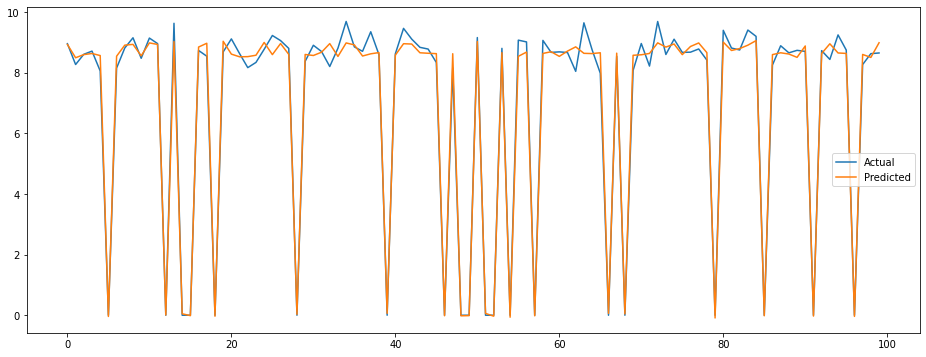

In [ ]:
# Plot first 100 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test[0:100])
plt.plot(y_pred[0:100])
plt.legend(['Actual','Predicted'])
plt.show()

**Regularization**

We have evaluated our model and it's performing well. But does it overfitting to data? 

To answer that, let's implement some regularization.

**Implementing Lasso Regression**

First, we will implement Lasso to penalize on L1 norm.

In [ ]:
# create lasso regression model
lasso = Lasso(alpha = 0.1 , max_iter = 3000)
# train the model
lasso.fit(X_train , y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=3000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
lasso.score(X_train , y_train)

0.980126546419207

In [ ]:
# predict the result
y_pred_lasso = lasso.predict(X_test)

In [ ]:
#Evaluation metrics for Lasso Regression
evaluation_metrics(y_test , y_pred_lasso, len(independent_variables))

Mean Squared Error : 0.2
Root Mean Squared Error : 0
Mean Absolute Error : 0.37
Mean Absolute Percentage Error : 11.38 %
R-Square : 0.98
Adjusted R-Square :  0.98


**Running Grid Search Cross Validation for Lasso Regression**

We can see that error rate is slightly increasing and R-square score decreased a little.

Let's try to find out best learning rate for Lasso Regression using Grid Search with Cross-Validation.

In [ ]:
#cross validation
lasso = Lasso()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
lasso_regressor = GridSearchCV(lasso , parameters , scoring='neg_mean_squared_error' , cv=5)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}

Using  {'alpha': 1e-08}  the negative mean squared error is:  -0.12660688477940707


In [ ]:
# predict the result
y_pred_lasso_cv = lasso_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Lasso Regression with cross validation
evaluation_metrics(y_test , y_pred_lasso_cv, X_test.shape[1])

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


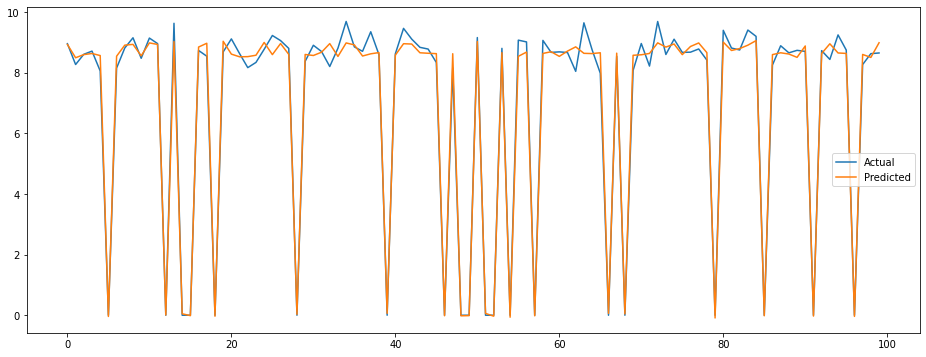

In [ ]:
# Plot first 100 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test[0:100])
plt.plot(y_pred_lasso_cv[0:100])
plt.legend(['Actual','Predicted'])
plt.show()

We can see that tuning the learning rate increases the evaluation scores.

Now let's try to use L2 norm of regularization.

**Implementing Ridge Regression**

In [ ]:
# create ridge regression model
ridge  = Ridge(alpha=0.1)
# train the model
ridge.fit(X_train,y_train)

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [ ]:
ridge.score(X_train, y_train)

0.9885345334700549

In [ ]:
# predict the result
y_pred_ridge = ridge.predict(X_test)

In [ ]:
#Evaluation metrics for Ridge Regression
evaluation_metrics(y_test , y_pred_ridge, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


**Running Grid Search Cross Validation for Ridge Regression**

In [ ]:
#cross validation
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-3,1e-1,1]}
ridge_regressor = GridSearchCV(ridge , parameters , scoring='neg_mean_squared_error' , cv=5)
ridge_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -0.1266068848094654


In [ ]:
# predict the result
y_pred_ridge_cv = ridge_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Ridge Regression with cross validation
evaluation_metrics(y_test , y_pred_ridge_cv, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


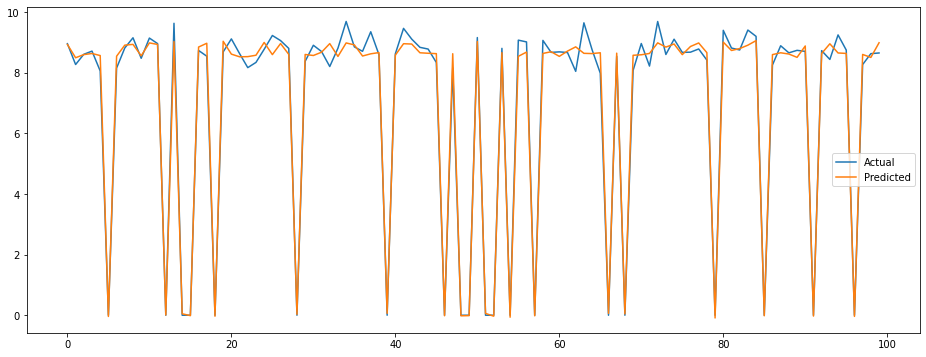

In [ ]:
# Plot first 100 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test[0:100])
plt.plot(y_pred_ridge_cv[0:100])
plt.legend(['Actual','Predicted'])
plt.show()

**Implementing Elastic net Regression**

In [ ]:
# Build elastic net regression model
elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
# treain the moodel
elasticnet.fit(X_train,y_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
elasticnet.score(X_train, y_train)

0.909327284292643

In [ ]:
# predict the result from elastic net model
y_pred_en = elasticnet.predict(X_test)

In [ ]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en, len(independent_variables))

Mean Squared Error : 0.8
Root Mean Squared Error : 1
Mean Absolute Error : 0.68
Mean Absolute Percentage Error : 30.75 %
R-Square : 0.91
Adjusted R-Square :  0.91


**Running Grid Search Cross Validation for Elastic Net Regression**

In [ ]:
#cross validation
elastic = ElasticNet()
parameters = {'alpha': [1e-10,1e-8,1e-5,1e-3,1e-1,1]}
elastic_regressor = GridSearchCV(elastic , parameters , scoring='neg_mean_squared_error' , cv=5)
elastic_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-10, 1e-08, 1e-05, 0.001, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [ ]:
# check the best value of learning rate
print("The best fit alpha value is found out to be :" ,elastic_regressor.best_params_)
print("\nUsing ",elastic_regressor.best_params_, " the negative mean squared error is: ", elastic_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1e-08}

Using  {'alpha': 1e-08}  the negative mean squared error is:  -0.12660688479423063


In [ ]:
# predict the result
y_pred_en_cv = elastic_regressor.predict(X_test)

In [ ]:
#Evaluation metrics for Elastic Net Regression
evaluation_metrics(y_test , y_pred_en_cv, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


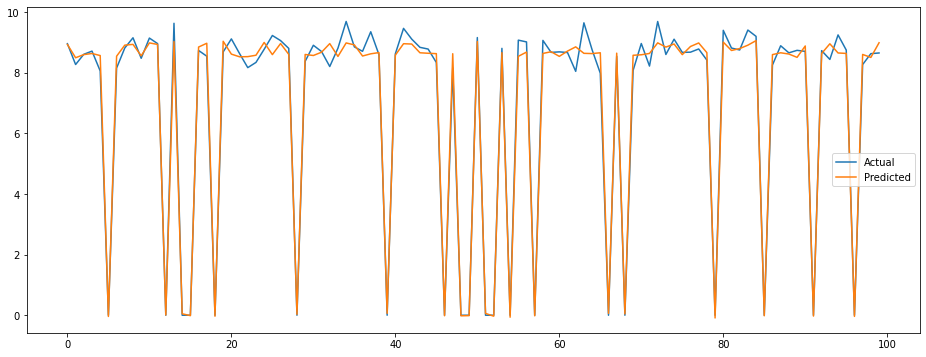

In [ ]:
# Plot first 100 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test[0:100])
plt.plot(y_pred_en_cv[0:100])
plt.legend(['Actual','Predicted'])
plt.show()

We have made 4 models. Sometimes it's useful to predict data on different models to increase accuracy of prediction and raise our confidence level.

Staking is a good way to combine all the predictions from different models into one. We can adjust weights for each model in stacking.

**Stack Model**

In [ ]:
# function to create average prediction of all models 
def stack_predict(test):
  # define weights for each model
  w_regresor = 1/4
  w_lasso = 1/4
  w_ridge = 1/4
  w_elastic = 1/4
  # get prediction from each model
  pred_regressor = regressor.predict(test)
  pred_lasso_cv = lasso_regressor.predict(test)
  pred_ridge_cv = ridge_regressor.predict(test)
  pred_en_cv = elastic_regressor.predict(test)
  # get weighted prediction
  w_pred = (w_regresor * pred_regressor) + (w_lasso * pred_lasso_cv) + (w_ridge * pred_ridge_cv) + (w_elastic * pred_en_cv)
  return w_pred

In [ ]:
# predict the result
y_pred_stack = stack_predict(X_test)

In [ ]:
# Evaluation metrics for Stack model
evaluation_metrics(y_test , y_pred_stack, len(independent_variables))

Mean Squared Error : 0.11
Root Mean Squared Error : 0
Mean Absolute Error : 0.25
Mean Absolute Percentage Error : 3.41 %
R-Square : 0.99
Adjusted R-Square :  0.99


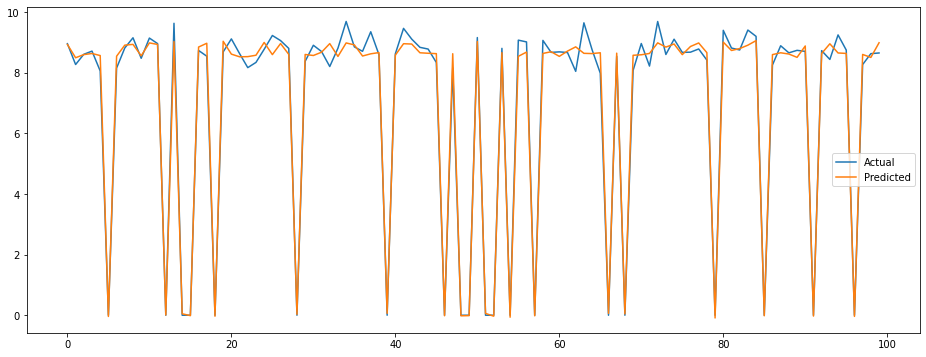

In [ ]:
# Plot first 100 observations between actual and predicted
plt.figure(figsize=(16,6))
plt.plot(y_test[0:100])
plt.plot(y_pred_stack[0:100])
plt.legend(['Actual','Predicted'])
plt.show()